**Univerisity of Pisa - M.Sc Computer Science, Artificial Intelligence**  
**Intelligent system for pattern recognition - a.a. 2021/22**

**Author:** Irene Pisani - i.pisani1@studenti.unipi.it - matricola 560104  
**Date:** 18 March 2022

### **1° MIDTERM: assignment n°5**
# **IMAGE PROCESSING: CLUSTERING OF SIFT DESCRIPTORS**

***Abstract.*** *Given a collection of images belonging to four thematic subsets, this project aims to extract SIFT descriptors from the considered images using the visual feature detector embedded in SIFT and aggregate all identified descriptors into a dataset. The main purpose is to run any clustering algorithm on this data to partition the descriptors into clusters: the obtained clusters were analysed by comparing the descriptors assigned to each cluster with the thematic classes of the images from which they were extracted (by computing a confusion matrix and a correlation matrix between the clusters and the four thematic images).*





---



## **1. Collection of images**

Starting from the *Object Class Recognition Image Database* (Microsoft Research Ltd, Cambridge UK) that collect a set of images belonging to 8 predefined themes, 4 different themes were selected from those available:

*   Theme 1: **Cow**
*   Theme 2: **Face**
*   Theme 3: **Car**
*   Theme 4: **Bike**

All images labelled with one of the above themes were used in this project: as each theme contains 30 different images, a collection of 120 selected images was used as the starting point.



## **1.1. Preliminary steps**

Python version 3.7 was used for this project.  
For the code below to work properly, you need to install **openCV** version 3.4.2.17, to import some auxiliary libraries, and to upload the image collection from Github.



In [1]:
pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 80.7 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
import cv2
import glob 

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

from sklearn.cluster import KMeans
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

Loading the collection of selected images. 

In [3]:
!git clone https://github.com/irenepisani/ISPR.git

Cloning into 'ISPR'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (270/270), done.
remote: Total 275 (delta 129), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (275/275), 23.50 MiB | 8.20 MiB/s, done.
Resolving deltas: 100% (129/129), done.



---

## **2. SIFT descriptors dataset generation**

The initial task is to process all previously selected images using the openCV library.  
The images are converted to greyscale before proceeding to process them with SIFT alghorithm; so, as first step, we have to construct a SIFT object to load alghorithm using `sift.create()`. Then, we can start using SIFT's built-in visual feature detector to identify points of interest (key points) of our images and compute the corresponding descriptors.  

We know that SIFT alghorithm implemented in openCV returns for each image only those keypoints for which `contrastThreshold` and `edgeThreshold` are satisfied, all others are discarded: this leads to a different number of keypoints being extracted from each image.  
However, knowing that our goal is to group all extracted SIFT descriptors into a dataset and perform a cluster partition on them, this imbalance in the dataset composition might cause the generation of an uneven dataset: for example, we might have a final dataset with a much larger number of descriptors coming from "bike-themed" images than from "face-themed" images.  
In order to avoid this phenomenon from affecting the clustering process, it was preferred to set a fixed number of key points to be extracted from each image.

This was done by using a specific parameter: `sift.create(nfeatures=150)`.  
By fixing this value we can retain, for each image, only the first 150 best features (ranked by their scores  that is measured as local contrast). In the end, we obtain a dataset composed by the same number of descriptors for each themes.

Finally, with the `sift.detectAndCompute()` function we can directly compute keypoints and descriptors; all the descriptors are aggregated in the resulting dataset and each one is associated with a label showing the theme of the image from which it was extracted.

In [4]:
# Assign to each image a label corresponding to its theme
def assignLabel (img_name):
	img_name = img_name[22]
	if img_name == "5":   # theme 5 = cow  --> label = 0
		return int(0)
	elif img_name == "6": # theme 6 = face --> label = 1
		return int(1)
	elif img_name == "7": # theme 7 = car  --> label = 2
		return int(2)
	else:                 # theme 8 = bike --> label = 3
		return int(3)

# Create a dataset of SIFT descriptors
def createDataset (path):
	
  # fix the number of key points to extract from each image (fixed num keypoints = 100)
	sift = cv2.xfeatures2d.SIFT_create(nfeatures=150)
	dataset = []     # initialize an empty dataset
	example_des = [] #initialize an empty set of descriptors for visual aim

  #for each image in our folder of selected image
	for img in glob.glob(path):
		
    # read image and convert image to gray scale
		image = cv2.imread(img)
		gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # extract key points and descriptors from the image
		key_points, descriptors = sift.detectAndCompute(gray_image, None)

		# draw key point for some images (- not mandatory for this assignment)
		if (img =="/content/ISPR/images_/5_16_s.bmp" or img =="/content/ISPR/images_/6_3_s.bmp"  or img=="/content/ISPR/images_/7_6_s.bmp" or img =="/content/ISPR/images_/8_5_s.bmp"):
			marked_image = cv2.drawKeypoints(gray_image, key_points, image ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
			cv2.imwrite('/content/ISPR/markedimages/'+img[22:-4]+'_kp.bmp', marked_image)
    	#extract some descriptors in order to visualize them as histograms
			example_des.append(descriptors)

    # create an array of labels (= theme of the image from which the descriptors has been extracted) 
		label = np.full((descriptors.shape[0],1), assignLabel(img))
    # add to each descriptors its label
		descriptors = np.concatenate((descriptors, label), axis=1)
    # add new descriptors to the final dataset
		dataset.append(descriptors) 

	dataset = np.vstack(dataset) # store dataset as np array 
  # (example) dataset = [[descriptor_1, label_1] ... [descriptor_n, label_n]]
	np.random.shuffle(dataset) # shuffle dataset 
	label = dataset[:, -1]     # dataset = [[descriptor_1] [descriptor_2] ... [descriptor_n]]
	dataset = dataset[:, :-1]  # label = [[label_1] [label_2] ... [label_n]]

	return dataset,label, example_des


In [5]:
path_folder = str("/content/ISPR/images_/*_s.bmp")
dataset, label, example_descriptors = createDataset(path_folder)

print("Dataset of SIFT descriptors:\n", dataset, "\n")
print("Our dataset is composed by", np.shape(dataset)[0], "descriptors.")
print("Each descriptors is represented by", np.shape(dataset)[1], "features.\n")
print("For each descriptor store the theme (label) of the image from which it was extracted in the following array:\n", label)
print("Element in position i corresponds to label of the i-th descriptors.")


Dataset of SIFT descriptors:
 [[  0.   4.  21. ...   0.   0.   0.]
 [  0.   0.   0. ...   1.  15.  28.]
 [  3.  10.  38. ...   1.   1.   0.]
 ...
 [ 64.   7.   1. ...   9.  18.  63.]
 [  0.   7. 119. ...  14.  15.  17.]
 [ 78.  38.   0. ...  20.   0.   0.]] 

Our dataset is composed by 17943 descriptors.
Each descriptors is represented by 128 features.

For each descriptor store the theme (label) of the image from which it was extracted in the following array:
 [1. 1. 0. ... 3. 2. 2.]
Element in position i corresponds to label of the i-th descriptors.


### **2.1. SIFT keypoints and descriptors: a visual analysis**

This section aims to explore the information provided by key points and descriptors computed so far.  

The following figure shows that key points can be drawn with the `drawKeypoints()` function: they are represented in their position on the image by a circle with specific size and orientation.  
More importantly for our purposes, it is also possible to give a visual rendering of the descriptors by representing them as histograms of gradient frequency (using magnitude and orientation).  
We know that SIFT descriptors are expressed as vectors composed of 128 features so we can plot the histogram by putting the feature index over the x-axis and the feature values (gradient frequency) over the y-axis.



In [6]:
def visualize (des):

	# show key poiny and descriptors in a graphic way 

	plt.rcParams['figure.figsize'] = [18, 12]
	plt.rcParams['figure.dpi'] = 200
	fig, axs = plt.subplots(nrows=4, ncols=3)
	fig.suptitle("\n Visual comparison between different themes", fontweight="bold")

	axs[0, 0].imshow(cv2.imread("/content/ISPR/markedimages/5_16_s_kp.bmp")) # image with COW thema
	axs[1, 0].imshow(cv2.imread("/content/ISPR/markedimages/6_3_s_kp.bmp"))  # image with FACE thema
	axs[2, 0].imshow(cv2.imread("/content/ISPR/markedimages/7_6_s_kp.bmp"))  # image with CAR thema
	axs[3, 0].imshow(cv2.imread("/content/ISPR/markedimages/8_5_s_kp.bmp"))  # image with BIKE thema
	for i in range(0,4):
		axs[i, 0].get_xaxis().set_visible(False)
		axs[i, 0].get_yaxis().set_visible(False)
	for i in range(len(des)):
		cow  = des[0][i] # 150 descriptors of a COW image 
		face = des[1][i] # 150 descriptors of a FACE image 
		car  = des[2][i] # 150 descriptors of a CAR image 
		bike = des[3][i] # 150 descriptors of a BIKE image 
		axs[0, 1].plot(cow, linewidth=1)
		axs[1, 1].plot(face, linewidth=1)
		axs[2, 1].plot(car, linewidth=1)
		axs[3, 1].plot(bike, linewidth=1)	
	axs[0, 2].plot(des[0][0], 'r-', linewidth=1) # single (first) descriptor of COW image 
	axs[1, 2].plot(des[1][0], 'g-', linewidth=1) # single (first) descriptor of FACE image 
	axs[2, 2].plot(des[2][0], 'b-', linewidth=1) # single (first) descriptor of CAR image 
	axs[3, 2].plot(des[3][0], 'y-', linewidth=1) # single (first) descriptor of BIKE image 
  # set axes label 
	for i in range(0,4):
		for j in range(1,3):
			axs[3,j].set_xlabel("Descriptor's features",  fontsize=8)
			axs[i,1].set_ylabel("Gradient frequency", fontsize=8)
  # set column and row label  
	for ax, col in zip(axs[0,:], ['KEYPOINTS', ' 150 DESCRIPTORS', 'SINGLE DESCRIPTOR']):
	    ax.annotate(col, (0.5, 1), xytext=(0, 10), ha='center', va='bottom',
	                xycoords='axes fraction', textcoords='offset points')
	for ax, row in zip(axs[:,0], ['COW image', 'FACE image', 'CAR image', 'BIKE image']):
	    ax.annotate(row, (0, 0.5), xytext=(-10, 0), ha='right', va='center',
	                rotation=90, xycoords='axes fraction',
	                textcoords='offset points')
	plt.show()
	return


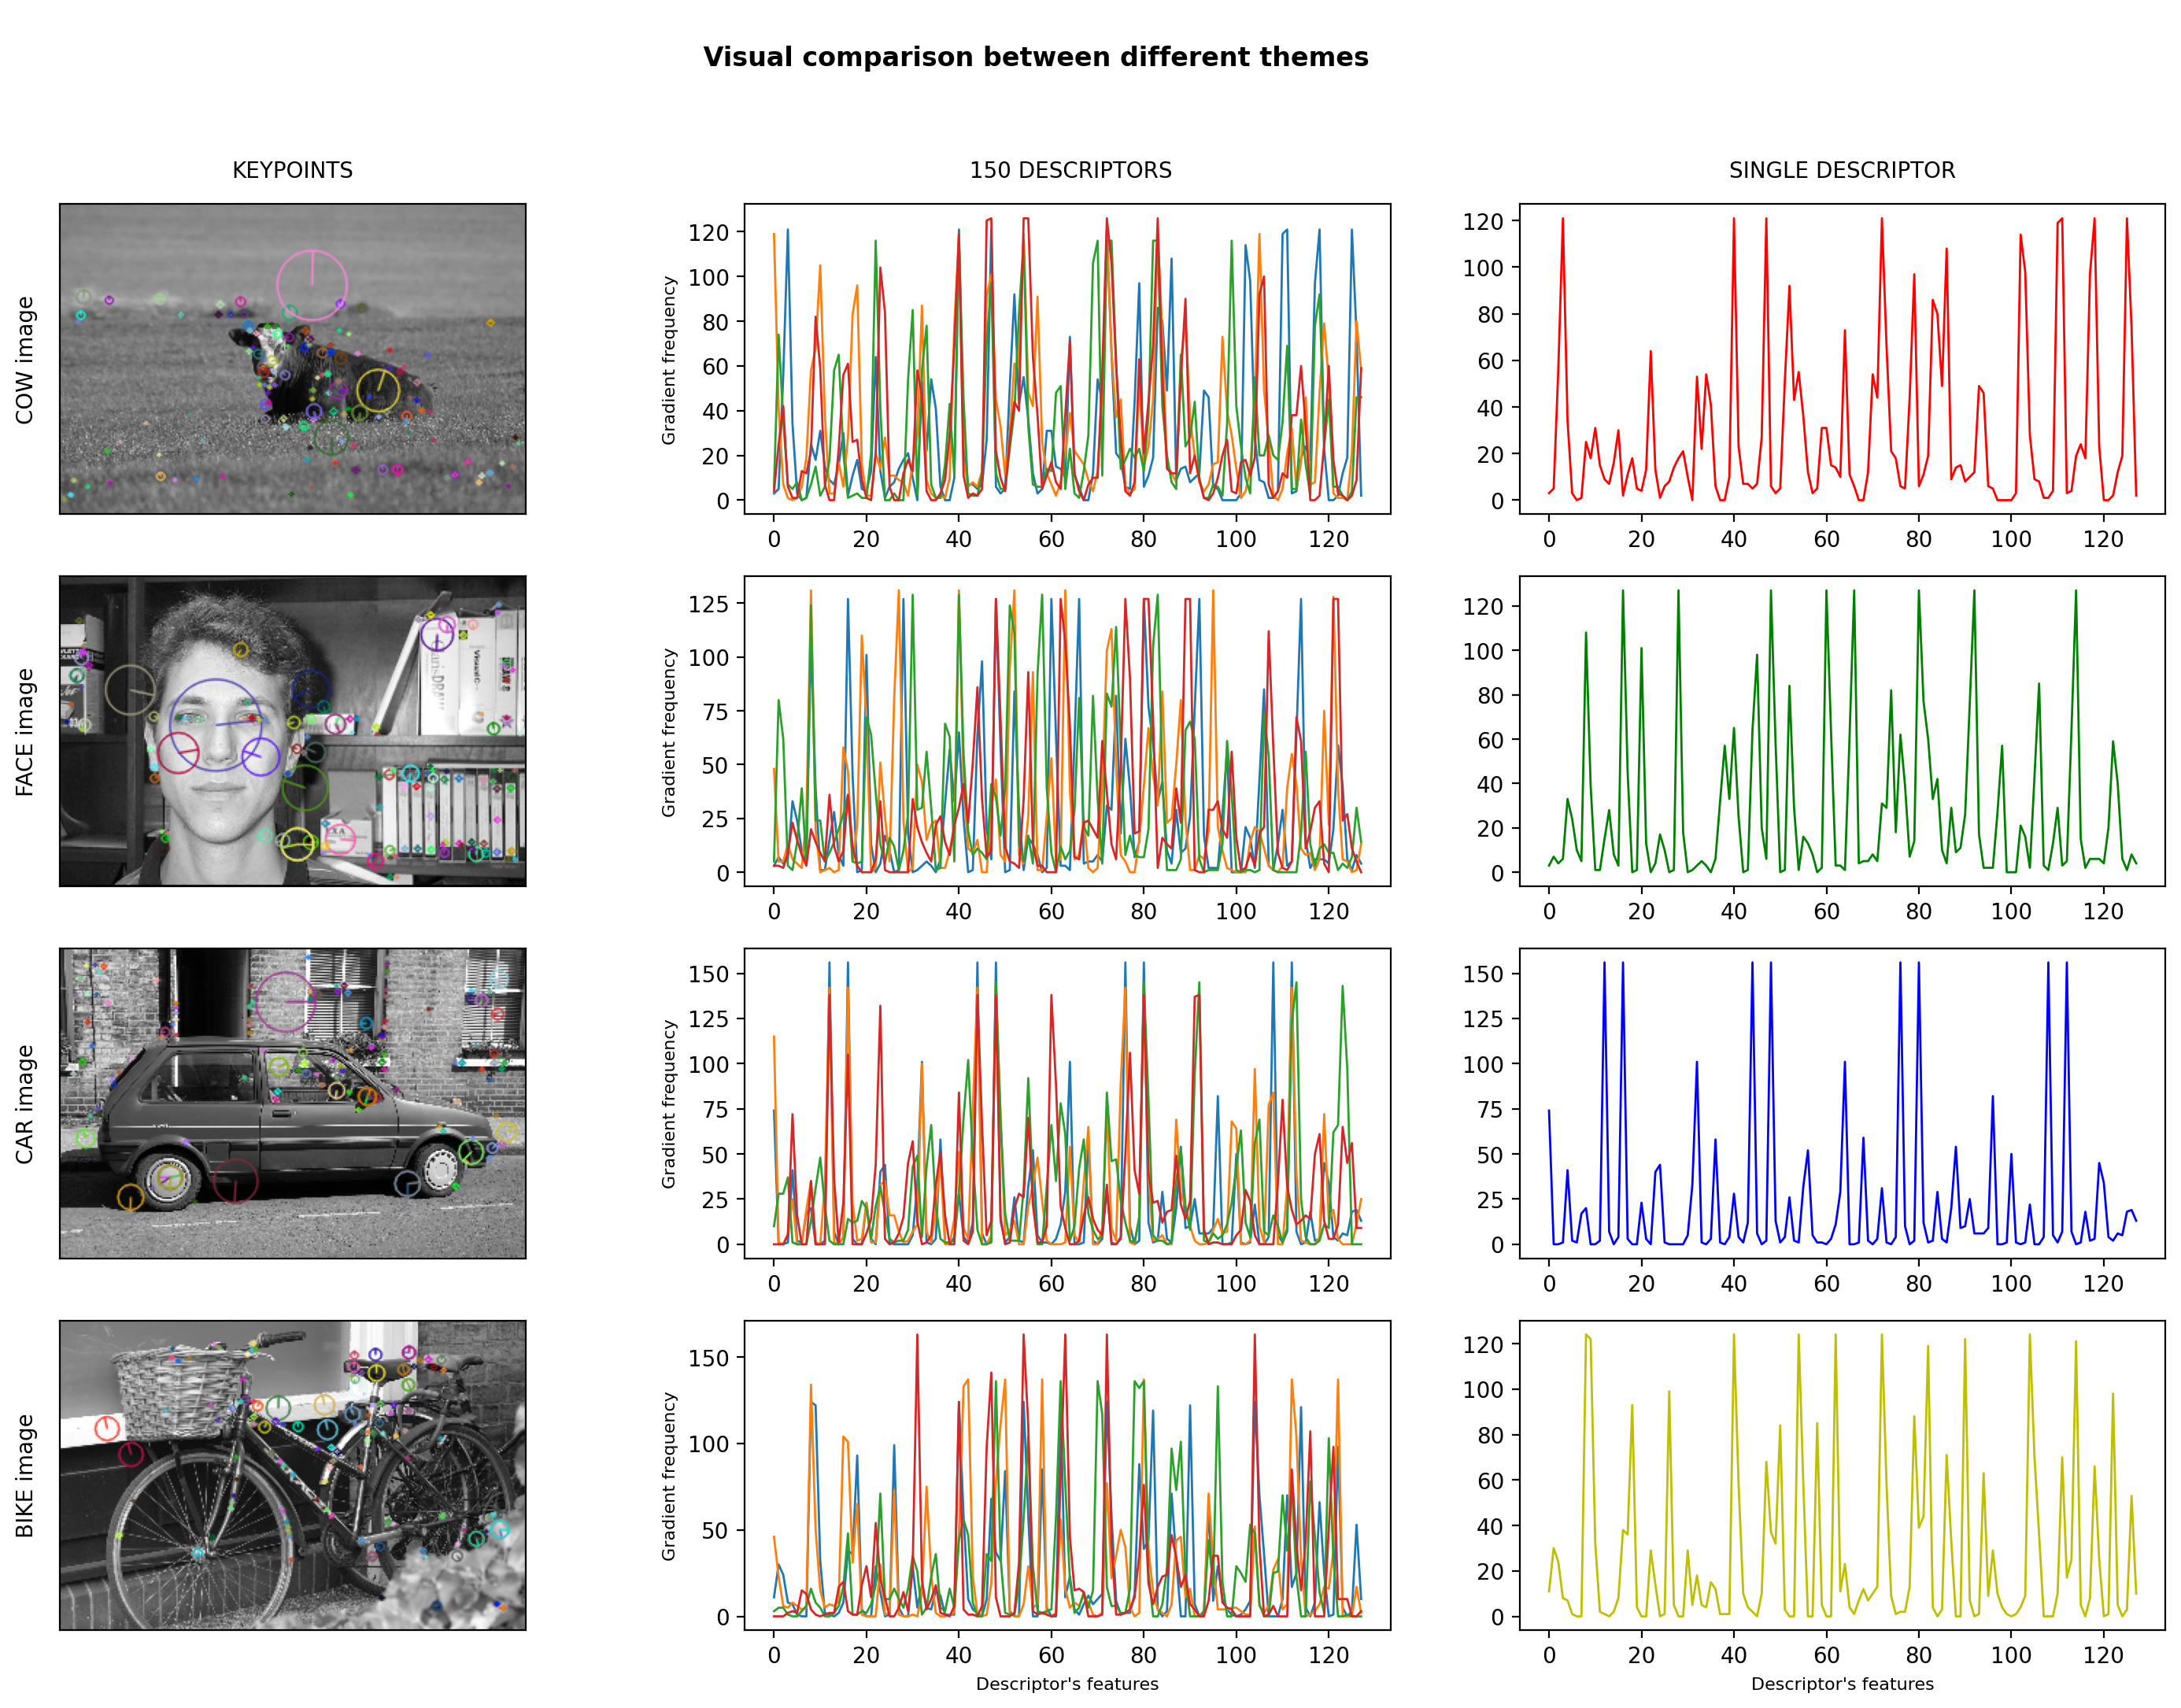

In [7]:
visualize(example_descriptors)

Looking at the figure above, it is difficult to establish through a simple visual comparison which pair of descriptors retains a higher degree of similarity: a descriptor extracted from the "bike"-themed image might be more similar to a descriptor extracted from the "car"-themed image than to another descriptor coming from the same theme.

In order to identify groups of descriptors that are similar to each other, it is possible to employ several clustering methods to obtain the desired grouping in an unsupervised manner.   
The following section go deeper into these strategies.





## **3. Clustering with K-Means**

To identify similar set of SIFT descriptors within our dataset we use **K-Means** clustering method. This algorithm has been choosen since it is a
simple squared-error partitioning method, very popular in context of Bag of Visual Words and image recognition/classification task. 
 
In this project we use the K-means implementation proposed by **Sci-Kit Learn**. The `KMeans(n_clusters=k).fit()` function load the algorithm with some specified parameter and apply it over the given dataset. In particulary, `k` parameter specified the number of groups in which the dataset will be partitioned. 

A first clustering experiment is performed by setting the value of k equal to 4: the result is a partition of the dataset into 4 clusters.  
*By obtaining such a partition, is it possible to find a correspondence between each of the predicted clusters and one of the 4 starting image themes?*  
This question motivated the initial choice of the k value. 
However, as will be discussed in section 5, taking the same number of image themes as the best value for k may not be the best choice since some descriptors associated with different themes may be more similar than descriptors associated with the same theme.  
Therefore, it proved necessary to carry out a study of k values in order to establish the most appropriate one. 

Anyway, whatever value we choose for k, the `generateCluster()` function associated to each descriptor in the dataset a label of the cluster to which it was assigned and returns the centroids of each clusters. 


In [8]:
def findNumCluster(dataset):
	
	#best_k = 4 # default k value
	test_k = range (5 , 50) # range of k values to be tested

	#find best value of k with SILHOUETTE METHOD
	silhouette = {}
	for k in test_k: 
    # for each value of k to be tested run k-means
		kmeans = KMeans(n_clusters=k).fit(dataset)
		labels_k = kmeans.labels_
    # compute silhoette scores and store it
		score_k = metrics.silhouette_score(dataset, labels_k)
		silhouette[k] = score_k
	# showsilhouette score by increasing k value
	plt.rcParams['figure.figsize'] = [12, 6]
	plt.rcParams['figure.dpi'] = 80
	plt.figure(figsize=(16,8))
	plt.plot(test_k, list(silhouette.values()), 'bx-')
	plt.xlabel('k (= num. cluster)')
	plt.ylabel('Silhouette score')
	plt.title('Silhouette Method to find optimal k')
	plt.show()
  
  # the best k value is the one for which the silhouette score is maximized
	best_k = max(silhouette, key=silhouette.get)
 
	return best_k

def generateCluster(dataset, k):
	
  # if k value is not given find it with silhouette method
	if k == None:
		k = findNumCluster(dataset)
		print("\nThe best value of k founded is", k, "\n Dataset will be partitioned in", k, "clusters.\n")

  # use k-means alghorithm to cluster dataset 
	kmeans = KMeans(n_clusters=k).fit(dataset)
	centroids = kmeans.cluster_centers_
	labels = kmeans.labels_

	return labels, centroids

In [9]:
computed_labels, centroids = generateCluster(dataset, k=4)

# show dataset as dataframe
dataset_df = pd.DataFrame(dataset)
dataset_df["cluster"] = computed_labels # add to each descriptors its cluster 
dataset_df["theme"]   = label # add to each descriptors its thema 
display(dataset_df)

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,cluster,theme
0,0.0,4.0,21.0,1.0,0.0,13.0,99.0,0.0,0.0,2.0,...,15.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,1,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,23.0,41.0,31.0,2.0,0.0,1.0,15.0,28.0,1,1.0
2,3.0,10.0,38.0,5.0,1.0,1.0,3.0,2.0,3.0,9.0,...,0.0,2.0,8.0,5.0,3.0,1.0,1.0,0.0,0,0.0
3,2.0,0.0,1.0,1.0,3.0,12.0,22.0,5.0,31.0,9.0,...,22.0,0.0,0.0,4.0,37.0,4.0,2.0,27.0,1,0.0
4,8.0,5.0,1.0,22.0,134.0,4.0,0.0,0.0,134.0,64.0,...,31.0,0.0,0.0,2.0,11.0,3.0,5.0,16.0,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17938,6.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,135.0,16.0,...,0.0,3.0,91.0,58.0,1.0,1.0,0.0,0.0,3,0.0
17939,0.0,0.0,3.0,39.0,48.0,35.0,6.0,0.0,6.0,8.0,...,74.0,20.0,3.0,0.0,0.0,0.0,0.0,19.0,1,0.0
17940,64.0,7.0,1.0,3.0,4.0,1.0,1.0,18.0,160.0,10.0,...,35.0,13.0,25.0,4.0,7.0,9.0,18.0,63.0,2,3.0
17941,0.0,7.0,119.0,38.0,7.0,4.0,6.0,0.0,0.0,2.0,...,4.0,3.0,44.0,65.0,6.0,14.0,15.0,17.0,0,2.0


### **3.1. Find best value of k with silhouette method**

To find the optimal value of k (number of clusters) the Silhouette method was used. Silhouette is a metric useful to study the separation distance between the resulting clusters since it show of how close each point in a cluster is to points in neighbouring clusters (bigger Silhoette value are preferred because indicate that the sample is far from neighbouring clusters).

The `finNumCluster()` function runs k-means several times with various number of k, computing each time a silhoette score; the function returns as optimal k the value for which the silhouette score is maximized.  
After all, the final clustering is then achieved by runs k-means with the the value of k obtained as explained above.

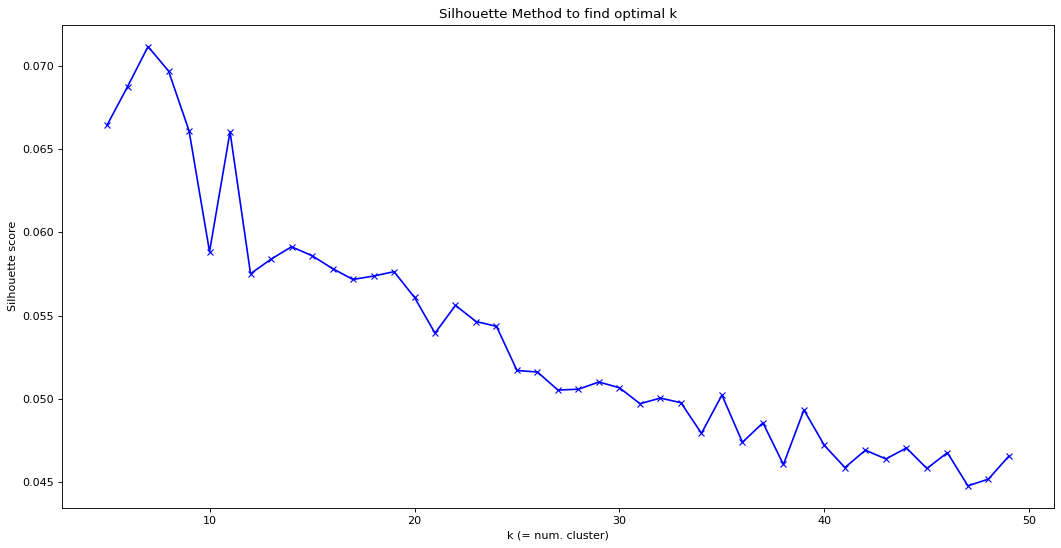


The best value of k founded is 7 
 Dataset will be partitioned in 7 clusters.



,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,cluster,theme
0,0.0,4.0,21.0,1.0,0.0,13.0,99.0,0.0,0.0,2.0,...,15.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,5,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,23.0,41.0,31.0,2.0,0.0,1.0,15.0,28.0,5,1.0
2,3.0,10.0,38.0,5.0,1.0,1.0,3.0,2.0,3.0,9.0,...,0.0,2.0,8.0,5.0,3.0,1.0,1.0,0.0,0,0.0
3,2.0,0.0,1.0,1.0,3.0,12.0,22.0,5.0,31.0,9.0,...,22.0,0.0,0.0,4.0,37.0,4.0,2.0,27.0,1,0.0
4,8.0,5.0,1.0,22.0,134.0,4.0,0.0,0.0,134.0,64.0,...,31.0,0.0,0.0,2.0,11.0,3.0,5.0,16.0,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17938,6.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,135.0,16.0,...,0.0,3.0,91.0,58.0,1.0,1.0,0.0,0.0,1,0.0
17939,0.0,0.0,3.0,39.0,48.0,35.0,6.0,0.0,6.0,8.0,...,74.0,20.0,3.0,0.0,0.0,0.0,0.0,19.0,3,0.0
17940,64.0,7.0,1.0,3.0,4.0,1.0,1.0,18.0,160.0,10.0,...,35.0,13.0,25.0,4.0,7.0,9.0,18.0,63.0,2,3.0
17941,0.0,7.0,119.0,38.0,7.0,4.0,6.0,0.0,0.0,2.0,...,4.0,3.0,44.0,65.0,6.0,14.0,15.0,17.0,0,2.0


In [10]:
computed_labels_k, centroids_k = generateCluster(dataset, k=None)

# show dataset as dataframe
dataset_k = pd.DataFrame(dataset)
dataset_k["cluster"] = computed_labels_k # add to each descriptors its cluster 
dataset_k["theme"]   = label # add to each descriptors its thema 
display(dataset_k)




---



## **4. Results analysis: comparison between obtained clusters and initial themes**

In this section, multiple approaches were implemented to analyse the possible relationship between the predicted clusters and the original themes. 





### **4.1. Confusion Matrix between clusters and themes**
A **Confusion matrix** between predicted clusters and actual themes  was computed to obtain for each cluster the number of descriptors that belong to a certain cluster and come from a given theme.  
 The `computeConfusionMatrix()` function returns us these desidered informations: each cell shows the number of descriptors that belong to the cluster indicated by the row index and that, at the same time, come from an image with the theme indicated by the column index. 


In [11]:
def computeConfusionMatrix(data):
	plt.rcParams['figure.figsize'] = [8, 6]
	plt.rcParams['figure.dpi'] = 100
  # compute confusion matrix 
	confusion_matrix = pd.crosstab(data["cluster"], data["theme"])
  # show confusion matrix as heatmap
	ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt="g")
	ax.set_title('\nConfusion Matrix\n');
	ax.set_xlabel('Actual Theme')
	ax.set_ylabel('Predicted Cluster');
	ax.xaxis.set_ticklabels(['Cow', 'Face', 'Car' , 'Bike'])
	plt.show()

	return confusion_matrix 


Confusion matrix between computed clusters (num. clusters  = 4) and actual themes. 



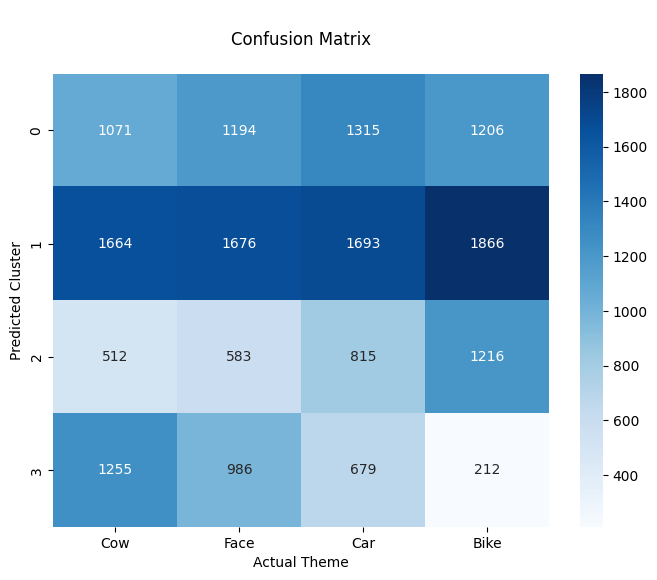



Confusion matrix between computed clusters (num. clusters  = optimal k) and actual themes.



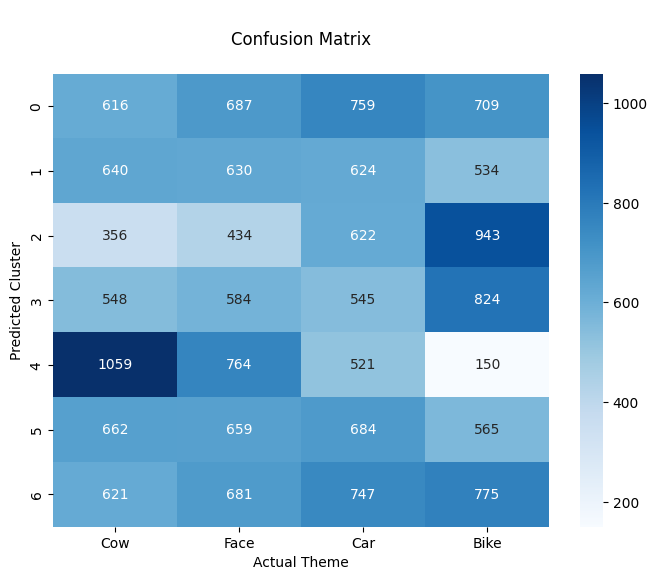

In [12]:
print("Confusion matrix between computed clusters (num. clusters  = 4) and actual themes. \n")
confusionMatrix = computeConfusionMatrix(dataset_df)

print("\n\nConfusion matrix between computed clusters (num. clusters  = optimal k) and actual themes.\n")
confusionMatrix_k = computeConfusionMatrix(dataset_k)

### **4.2. Correlation matrix between clusters and themes**

As mentioned before, we can represent SIFT descriptors as histograms and we can compare two different histograms using the function `compareHist()` provided by OpenCV to obtain a numerical parameter expressing how well two histograms match each other. However, to do this we need to choose a metric expressing how well both histograms match.  
The comparison could be performed on the basis of a few different metrics: the one chosen in this task is the **Correlation** calculated through the `HISTCMP_CORREL` function. More in general we can use this metric to compare different SIFT descriptors.  

We know that while partitioning the dataset into clusters we also obtained the centroids of each cluster: these centroids are 128 feature vectors that we can consider as histograms to compare them with other histograms of SIFT descriptors.

Here a **correlation matrix** between clusters and themes was calculated to obtain for each cluster, the correlation between its centroid and descriptors belonging to such cluster and randomly chosen from a certain theme.

More in details, we can use the `computeCorrelationMatrix()` to compute a matrix where each cell shows the correlation between the centroid of the cluster indicated by the row index and a random descriptors belonging to the same cluster coming from an image with the theme indicated in the column index.

Example: given the centroid of i-th cluster it will be compare with:   
- a descriptor coming from theme "cow" and belonging to cluster i;
- a descriptor coming from theme "face" and belonging to cluster i;
- a descriptor coming from theme "car" and belonging to cluster i;
- a descriptor coming from theme "bike" and belonging to cluster i.  
This procedure will be repeated for each cluster centroid and since we are working with random sample everything will be repeated several times. The mean of these different tests was taken as result for the final correlation matrix.

In [13]:
def computeCorrelationMatrix(dataset, centroid):
	
	random_test=100
	theme_value   = dataset["theme"].nunique()   # get number of different predicted cluster 
	cluster_value = len(centroid)
	correlation_matrix = np.zeros((cluster_value, theme_value)) # initilize a correlation matrix 

	for k in range(0, random_test): # perform 50 test 
		
		# for each cluster and each team repeat...
		for i in range(0, cluster_value):
			for j in range(0, theme_value):
				
				des1 = np.array(centroid[i], dtype="float32") # get i-th centroid 
				des2 = dataset.loc[(dataset["theme"]==j) & (dataset["cluster"] == i)]   # get all descriptor with theme label equal to j and i 
				rand_des2 = np.array(des2.sample(), dtype="float32") # get one random  descriptor with theme label equal to j
				
				# compute correlation by comparing histrogram of the 2 random extracted descriptors
				correlation = cv2.compareHist(des1, rand_des2[0][0:-2], cv2.HISTCMP_CORREL)
				# store correlation in the correct position in the correlation matrix 
				correlation_matrix[i][j] += correlation

	#compute mean over the result 
	correlation_matrix = correlation_matrix/random_test
	# show as dataframe 
	correlation_matrix = pd.DataFrame(correlation_matrix)
	
	correlationM = pd.concat([pd.concat(
        [correlation_matrix],
        keys=['Actual Theme'], axis=1)],
    		keys=['Centroid'])
  
	plt.rcParams['figure.figsize'] = [8, 6]
	plt.rcParams['figure.dpi'] = 100

	ax = sns.heatmap(correlationM, annot=True, cmap='Greens', fmt="g")
	ax.set_title('\n Correlation Matrix \n');
	ax.set_xlabel('Actual Theme')
	ax.set_ylabel('Predicted Cluster');
	ax.xaxis.set_ticklabels(['Cow descriptors', 'Face descriptors', 'Car descriptors' , 'Bike descriptors'])
	plt.show()

	return correlationM

Compare CENTROID and DESCRIPTOR (coming from same cluster): 

Correlation matrix between computed centroids (num. clusters  = 4) and actual themes. 



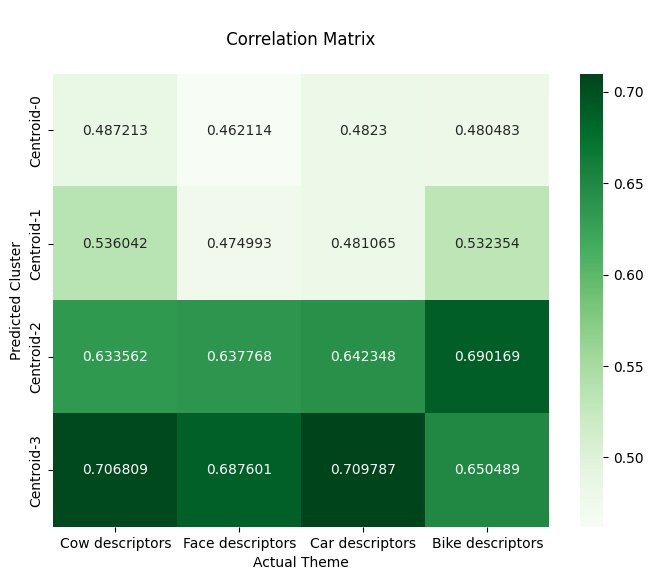


Correlation matrix between computed clusters (num. clusters  = optimal k) and actual themes. 



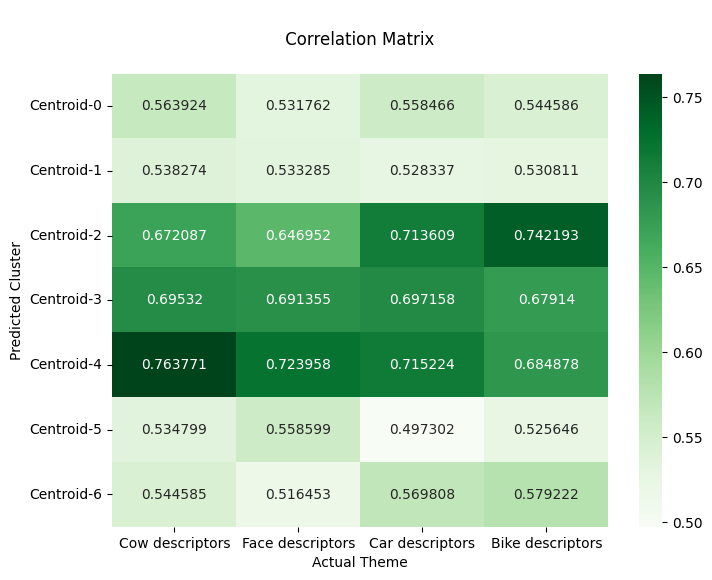

In [14]:
print("Compare CENTROID and DESCRIPTOR (coming from same cluster): \n")

print("Correlation matrix between computed centroids (num. clusters  = 4) and actual themes. \n")
correlation_matrix = computeCorrelationMatrix(dataset_df, centroids)

print("\nCorrelation matrix between computed clusters (num. clusters  = optimal k) and actual themes. \n")
correlation_matrix_k = computeCorrelationMatrix(dataset_k, centroids_k)


---

## **5. Conclusions**

### **5.1. Result obtained by partitioning dataset in 4 clusters.**

By observing the confusion matrix and the correlation matrix we can draw the following considerations.

One cluster, out of the four clusters available, contains a clear predominance of descriptors extracted from "cow"-themed images and less descriptors coming from images with other themes. The correlation matrix inform us that the centroid of this cluster has the highest level of correlation mesearured at all (between 0.65 and 0.70).   
One of the other clusters behaves in the same way, it groups together descriptors extracted mainly from images with  "bike" theme and it has a very high score in the correlation matrix (between 0.60 and 0.70).  
From these first two observations we can deduce that these clusters are respectively representative of some peculiarities of the images with the theme "cow" and "bike". Given the similarity of the descriptors belonging to these clusters with their respective centroids, we can deduce that the elements of these clusters are probably denser near the centroids and that these clusters, grouping very similar descriptors, are definitely highly representative for the visual information they describe.


Regarding the two remaining clusters, the one represented by the darkest row in the confusion matrix contains the majority of all the descriptors in our dataset (without a clear predominance of descriptors belonging to a specific theme).   
The last cluster also groups together descriptors belonging in equal numbers to each of the 4 themes. From here, we can deduce that these last two clusters are representative of some characteristics shared by all the image themes taken into consideration.  
Centroids of these cluster have low correlation values with the descriptors coming from different themes: correlation matrix reports values between about 0.4 and 0.55. We can deduce that the descriptors assigned to these clusters are more scatteredly arranged around the respective centroids.

However, by reasoning on themes rather than on clusters (i.e. by analysing the columns of the confusion matrix instead of the rows) we can add the following considerations.  
The majority of the descriptors coming from images with the "cow" theme, as well as those coming from images with the "face" and "bike" themes are distributed in 3 clusters; only the majority of the descriptors coming from images with the "car" theme are distributed in 2 clusters.   
None of the themes seems to be well represented by a single cluster; this statement, even if is not really informative, allows us to firmly conclude that the 4 clusters identified do not directly correspond to the 4 themes.
This conclusion justifies the previous assumption (ref. Section 3)  stating that the optimal number of clusters into which we should divide our dataset might not be 4. 


### **5.1. Result obtained by partitioning dataset in 7 (= optimal k) clusters.**

Again, we report the conclusions drawn by looking at confusion and correlation matrices.

Four, out of 7, clusters are composed of descriptors coming in equal numbers from each of the 4 available image themes; we can deduce that each of these clusters is representative of a feature shared between images coming from all themes. Within the correlation matrix, this four clusteers have correlation values between centroids and descriptors bounded between 0.4 and 0.5. It can be assumed that the descriptors belonging to these clusters are arranged around their centroids in a more scattered manner. 

The remaining 3 clusters mainly group together descriptors from images with a specific theme: respectively "cow", "bike", and again "bike". We may assume these cluster contains descriptors decribing some typical characteristics of "cow"-themed or "bike"-themed images. These clusters show very high correlation values (bounded  in range 0.65-0.75) between their centroids and the descriptitors they are composed by.  
In addition, we can assume that the elements of these clusters are more densely packed near the centroids; due to the grouping of extremely similar descriptors it is possible to highlight the representativeness of these clusters.

As before, it is possible to reason in terms of themes (columns instead of rows) to make some assessments on the distribution in clusters of descriptors coming from a particular theme.  
About half of the descriptors coming from images with the theme "cow" are grouped in only one cluster and about half of the descriptors coming from images with the theme "bike" are distributed in only two clusters. Descriptors from "face" and "car"-themed images are distributed more or less equally among all 7 clusters. 








---

## **6. Further developments**

Moreover, it is possible to adopt some additional approaches to improve quality of the employed procedures and, consequently, the consistency of the possible results. Some further developments are listed below:


1. **Change the fixed number of key points to be extracted.** One of the first steps was to set the number of key points (150) to be extracted from each image in our collection. *Would increasing or decreasing this value lead to different results? If yes, which changes in the results would this entail?*

2. **Search for natural clusters by visual analysis.** The fact that each element (i.e., each SIFT descriptor) in our dataset is described by 128 features makes it difficult to graphically render the distribution of elements (i.e. points) in a 128-dimensional space.   
Adopting some dimensionality reduction techniques (e.g. PCA, Principal Component Analysis), thus focusing attention on only a few salient features, would make it easier to graphically show the distribution of our data. This turns in make easier to find possible natural clusters of similar data through a simple visual analysis. *But our descriptor are really distributed in some k natural cluster?*

3. **Analyze the partition of the dataset in a number of clusters much greater than 50.**
This study focused on the behavior of the clustering process with a default cluster number smaller than 50. A more accurate analisys on the results generated by a partition into k clusters, with k >> 50 might deserve as much attention. *Could we have found more significant and representative clusters using a bigger k value?*

4.  **Employement of further metrics  or method in the comparison between predicted clusters and image themes.** In Section 4 a confusion matrix and the correlation metric were used to study the correspondences between clusters and themes; however, in addition to the correlation, openCV provides additional metrics for comparing histograms. *Does the adoption of other methods of comparison lead to additional conclusions?*




---


## **7. Source and references**




* [Collection of images](http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip)
*   [Scikit Learn, clustering with K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
*   [Scikit Learn, Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
*   [OpenCV, Histogram comparison](https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html)
*   [OpenCV, SIFT](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)
*   [OpenCV, SIFT extractor and detector](https://docs.opencv.org/3.4/d5/d51/group__features2d__main.html#ga89ce54823df44e7be4e43511c1d44553)